In [ ]:
# DO NOT REMOVE

# Compute double truncated GR from seismicity

In [9]:
%matplotlib inline
import os
import re
import sys
import h5py
import numpy
try:
    import cPickle as pickle
except:
    import pickle

from collections import Counter
#from prettytable import PrettyTable

from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser
from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.occurrence.utils import get_completeness_counts
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_trunc_gr_model

from oqmbt.oqt_project import OQtProject
from oqmbt.tools.area import create_catalogue

In [10]:
prj_path = "/Users/kjohnson/GEM/Regions/paisl18/project/paisl.oqmbtp"
os.environ["OQMBT_PROJECT"] = prj_path

In [11]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
print ('Project filename:', project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
#
# hdf5 files
compl_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.compl_hdf5_filename)
eqk_rates_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.eqk_rates_hdf5_filename)
#
# set source ID
try:
    area_source_ids_list = getattr(oqtkp,'active_source_id')
except:
    print ('Active source ID not defined in the OQMBT project')
    area_source_ids_list = ['1']
#
# info 
print ('Processing model with ID:', model_id)
print ('Processing area source with ID:', area_source_ids_list)

Project filename: /Users/kjohnson/GEM/Regions/paisl18/project/paisl.oqmbtp
Processing model with ID: model02
Processing area source with ID: ['1']


In [12]:
area_source_ids_list = ['16']

In [13]:
# Width of bins used to discretise the MFDs
binwidth = float(model.mfd_binwidth)

## Summary of GR parameters assigned to area sources

## Read catalogue

In [7]:
print (oqtkp.models[model_id].declustered_catalogue_pickle_filename)
pickle_filename = os.path.join(oqtkp.directory, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print ('The catalogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

model_2_-_learning_catalogue.pkl
The catalogue contains 2867 earthquakes


In [14]:
catalogue_filename = '/Users/kjohnson/GEM/Regions/paisl18/data/catalogues/locations/FinalCatalog/Simplified/PI_final_crustal.csv'
parser = CsvCatalogueParser(catalogue_filename)
catalogue = parser.read_file()

Catalogue Attribute 360 is not a recognised catalogue key
Catalogue Attribute  is not a recognised catalogue key


### Create catalogue for the selected areas

In [15]:
fcatal = create_catalogue(model, catalogue, area_source_ids_list)

Total number of earthquakes selected 192


In [16]:
mmin_model = float(model.catalogue_cutoff_magnitude)
print ('Minimum magnitude considered for the model is: ', mmin_model)
mmax_obs = float(max(fcatal.data['magnitude']))
print ('Maximum observed magnitude is: ', mmax_obs)

Minimum magnitude considered for the model is:  3.5
Maximum observed magnitude is:  6.66


In [18]:
if 1:
    # set the csv file name
    aa ="/Users/kjohnson/GEM/Regions/paisl18/data/sub_cata"
    #aa = "sub_cata"
    csv_filename = '{:s}/{:s}-{:s}-v2.csv'.format(aa, model_id, area_source_ids_list[0])
    #
    #csv_filename = "/Users/kjohnson/GEM/Regions/paisl18/project/declustered.csv"
    print(csv_filename)
    # Sub-catalogue
    sub_cata = CsvCatalogueWriter(csv_filename) 

    # Write the purged catalogue
 #   sub_cata.write_file(fcatal)
    sub_cata.write_file(fcatal)
    print("Catalogue successfully written to %s" % csv_filename)

/Users/kjohnson/GEM/Regions/paisl18/data/sub_cata/model02-16-v2.csv
Catalogue successfully written to /Users/kjohnson/GEM/Regions/paisl18/data/sub_cata/model02-16-v2.csv


### Load the completeness table

In [9]:
compl_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.compl_hdf5_filename)
print ('Reading {:s}\n'.format(compl_hdf5_filename))
fhdf5 = h5py.File(compl_hdf5_filename,'r')

grp = fhdf5[model_id]
src_id = area_source_ids_list[0]
if src_id in grp.keys():
    compl_table = grp[src_id][()]
    print ('Found completeness table for: <%s>' % (src_id))
else:
    print ('The .hdf5 file does not contain completeness table for source {:s}'.format(src_id))
    if 'whole_catalogue' in grp.keys():
        compl_table = grp['whole_catalogue'][()]
        print ('Using the default completeness table set for the whole catalogue')
    else:
        print ('Default completeness table (whole catalogue) not defined')
        raise ValueError()
        compl_table = None
print ('\nCompleteness table:')
print (compl_table)
fhdf5.close()

Reading /Users/kjohnson/GEM/Regions/paisl18/project/completeness.hdf5

The .hdf5 file does not contain completeness table for source 1
Using the default completeness table set for the whole catalogue

Completeness table:
[[ 1969.      5. ]
 [ 1969.      5.5]
 [ 1931.      6. ]
 [ 1931.      6.5]
 [ 1931.      7. ]
 [ 1931.      7.5]
 [ 1931.      8. ]]


## Double truncated magnitude-frequency distribution (MFD)

In [10]:
#
# selecting earthquakes
idx = numpy.nonzero(compl_table[:,1] < numpy.max(fcatal.data['magnitude']))
weichert_config = {'magnitude_interval': 0.1, 
                   'reference_magnitude': 0.0}
weichert = Weichert()
bval_wei, sigmab, aval_wei, sigmaa = weichert.calculate(fcatal, weichert_config, 
                                                        completeness=compl_table)
#
# info
print ('bval: %.6f (sigma=%.3f)' % (bval_wei, sigmab))
print ('aval: %.6f (sigma=%.3f)' % (aval_wei, sigmaa))
#
# computing seismicity rates
cent_mag, t_per, n_obs = get_completeness_counts(fcatal, compl_table, binwidth)

bval: 0.958248 (sigma=0.664)
aval: 4.332605 (sigma=0.097)


In [11]:
print('Updating', eqk_rates_hdf5_filename)
fhdf5 = h5py.File(eqk_rates_hdf5_filename, 'a')
#
# update/create group
if model_id in fhdf5.keys():
    print ('    Group exists. Set group %s' % (model_id))
    grp = fhdf5[model_id]
else:
    print ('    Create group: %s' % (model_id))
    grp = fhdf5.create_group(model_id)
#
# Update/create dataset
rates = numpy.array([cent_mag, t_per, n_obs])
if src_id in grp:
    del grp[src_id]
print('    Creating dataset %s' % (src_id))
dataset = grp.create_dataset(src_id, data=rates)
fhdf5.close()

Updating /Users/kjohnson/GEM/Regions/paisl18/project/eqk_rates.hdf5
    Group exists. Set group model02
    Creating dataset 1


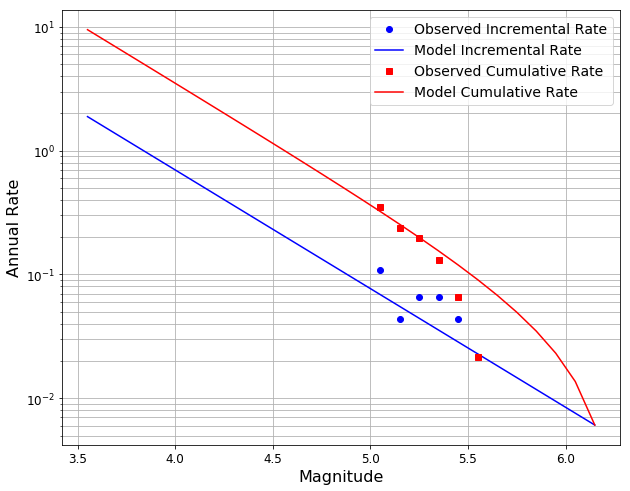

In [12]:
plot_trunc_gr_model(aval_wei, bval_wei, mmin_model, mmax_obs, binwidth, catalogue=fcatal,
        completeness=compl_table)

In [13]:
#
# Update the project info
c = Counter(fcatal.data['comment'])
weights = {}
annual_rate_source = []
#
# 
for srcid in area_source_ids_list:
    #
    # Computing weight
    num_eqs_source = float(c['%s' % srcid])
    weights[srcid] = num_eqs_source / fcatal.get_number_events()
    print ('source', srcid, \
           ' | num. of eqks [eqks] %6.2f' % (c['%s' % srcid]), \
           ' | weight %s' % (weights[srcid]))
    #
    # attaching source to model 
    src = model.get_source(srcid) 
    src.a_gr=numpy.log10(10**aval_wei * weights[srcid])
    src.b_gr=bval_wei
#
# saving the project
oqtkp.save(log=True)
#
# check of the weight
checkw = 0.0
for key in weights:
    checkw += weights[key]
print ('check:', checkw)

source 1  | num. of eqks [eqks]  18.00  | weight 1.0
Project saved into file /Users/kjohnson/GEM/Regions/paisl18/project/paisl.oqmbtp
check: 1.0
